# Semantic Segmentation of satellite imagery using U-Net

## Step 2: Model building

Adapted from the [code by Dr. Sreenivas Bhattiprolu](https://github.com/bnsreenu/python_for_microscopists/tree/master/230_landcover_dataset_segmentation). Also see the [tutorial](https://www.youtube.com/watch?v=0W6MKZqSke8)

Dataset: https://www.kaggle.com/datasets/adrianboguszewski/landcoverai?resource=download

This step was done in **Google Colab** for performance reasons. That is why some installs and settings had to be made first.

In [1]:
# Install necessary library
!pip install segmentation_models
!pip install -U tensorflow keras segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.6 MB/s eta 0:00:00


In [2]:
# Mount Google Drive, where the image files are saved
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# # Remove existing directories
# !rm -r /content/gdrive/MyDrive/final_project/data/landcoverai/train_images/
# !rm -r /content/gdrive/MyDrive/final_project/data/landcoverai/train_masks/
# !rm -r /content/gdrive/MyDrive/final_project/data/landcoverai/val_images/
# !rm -r /content/gdrive/MyDrive/final_project/data/landcoverai/val_masks/

In [4]:
# List existing image files (zipped)
!ls /content/gdrive/MyDrive/final_project/data/

landcoverai


In [5]:
# # Unzip one archive to have access to the images
# !unzip /content/gdrive/MyDrive/final_project/data/landcover_ai_patches_balanced_2000.zip -d /content/gdrive/MyDrive/final_project/data/landcoverai/


In [6]:
# Necessary because of a bug https://github.com/qubvel/segmentation_models/issues/374
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [7]:
import os
import random
from pathlib import Path

import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models as sm
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Segmentation Models: using `tf.keras` framework.


In [8]:
# In case the model gets very slow, may be due to a bug in TF2.0. Uncomment this.
# https://github.com/tensorflow/tensorflow/issues/33024
# tf.compat.v1.disable_eager_execution()

# Also check this in case you notice training to be getting increasingly slow each epoch.
# https://stackoverflow.com/questions/53683164/keras-occupies-an-indefinitely-increasing-amount-of-memory-for-each-epoch

In [9]:
# Define needed directory paths
dir_root = Path("/content/gdrive/MyDrive/final_project/data/landcoverai/")
dir_train_img = Path(dir_root, "train_images/train/")
dir_train_mask = Path(dir_root, "train_masks/train/")
dir_val_img = Path(dir_root, "val_images/val/")
dir_val_mask = Path(dir_root, "val_masks/val/")
dir_models = Path("/content/gdrive/MyDrive/final_project/data/models/")




# Show how many image files exist
for dir in [dir_train_img, dir_train_mask, dir_val_img, dir_val_mask]:
    files = patch_files = [file for file in dir.iterdir()]
    print(f"{dir} has {len(files)} images.")

/content/gdrive/MyDrive/final_project/data/landcoverai/train_images/train has 2250 images.
/content/gdrive/MyDrive/final_project/data/landcoverai/train_masks/train has 2250 images.
/content/gdrive/MyDrive/final_project/data/landcoverai/val_images/val has 750 images.
/content/gdrive/MyDrive/final_project/data/landcoverai/val_masks/val has 750 images.


In [10]:
classes = {
    0: "Not classified",
    1: "Building",
    2: "Woodland",
    3: "Water",
    4: "Roads",
}

### Visualize random patch alongside its mask

In [11]:
def plot_image_and_mask(image: Path):
    """
    Function to plot an image alongside its mask.
    """
    img = cv2.imread(image.as_posix())
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask_path = Path(image.as_posix().replace("/train_images/", "/train_masks/"))
    mask = cv2.imread(mask_path.as_posix())

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    ax1.imshow(img)
    ax1.set_title("Channel 0")

    norm = mpl.colors.Normalize(vmin=0, vmax=4)
    cmap = plt.get_cmap("viridis")

    ax2.imshow(mask[:, :, 1], cmap=cmap, norm=norm)
    ax2.set_title("Mask")

    plt.show()


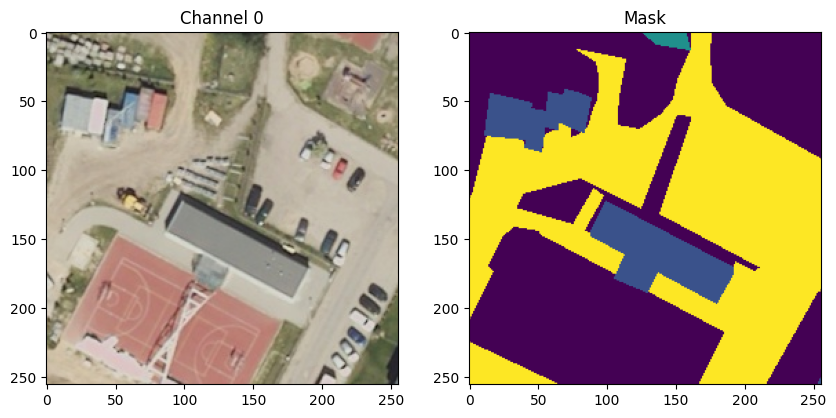

In [12]:
# Get paths of all images
img_files = [file for file in dir_train_img.iterdir()]

# Get random image from all images
img_path = np.random.choice(img_files)

plot_image_and_mask(img_path)


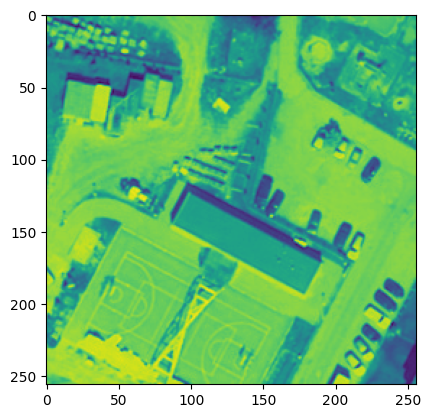

In [13]:
#Quick understanding of the dataset
temp_img = cv2.imread(img_path) #3 channels / spectral bands
plt.imshow(temp_img[:,:,0]) #View each channel...
plt.imshow(temp_img[:,:,1]) #View each channel...
plt.imshow(temp_img[:,:,2]) #View each channel...
temp_mask = cv2.imread(img_path) #3 channels but all same.






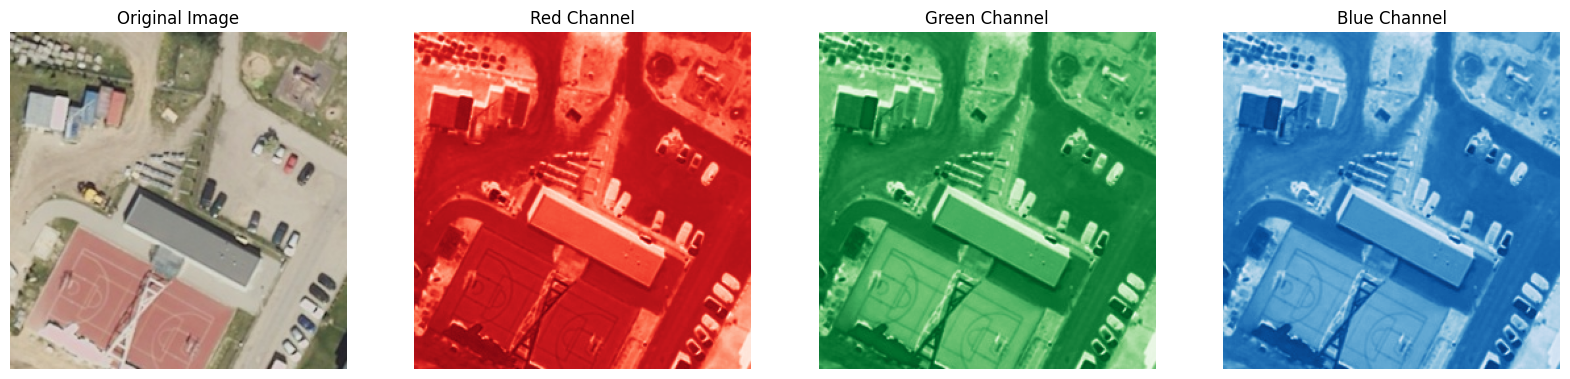

In [14]:


import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread(img_path)  # Reads in BGR format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Split the channels
red_channel = img[:, :, 0]  # Red channel
green_channel = img[:, :, 1]  # Green channel
blue_channel = img[:, :, 2]  # Blue channel

# Plot the channels
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(img)  # Original image
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(red_channel, cmap="Reds")
axs[1].set_title("Red Channel")
axs[1].axis("off")

axs[2].imshow(green_channel, cmap="Greens")
axs[2].set_title("Green Channel")
axs[2].axis("off")

axs[3].imshow(blue_channel, cmap="Blues")
axs[3].set_title("Blue Channel")
axs[3].axis("off")

plt.show()

In [15]:
labels, count = np.unique(temp_mask[:,:,0], return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)

Labels are:  [  3  11  12  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28
  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46
  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64
  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218]  and the counts are:  [   1    2    2    2    1    1    4    1    2    1    7    6    4    5
    3   12    8    8   13   11   11   16   19   1

In [16]:
import numpy as np

# Example: Assume temp_mask[:,:,0] contains many unique labels
labels, count = np.unique(temp_mask[:, :, 0], return_counts=True)
print("Original Labels:", labels)

# Create a mapping dictionary to reassign labels to [0,1,2,3,...]
# Ensure all labels in temp_mask are included in the mapping
label_mapping = {old_label: new_label for new_label, old_label in enumerate(labels)} #Changed labels[:4] to labels

# Apply mapping to mask
remapped_mask = np.vectorize(label_mapping.get)(temp_mask[:, :, 0])

# Print new unique labels
new_labels, new_count = np.unique(remapped_mask, return_counts=True)
print("New Labels:", new_labels)
print("New Counts:", new_count)

Original Labels: [  3  11  12  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28
  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46
  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64
  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218]
New Labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30 

### Define Generator for images and masks

In [17]:

import segmentation_models as sm

seed = 24
batch_size = 16  # Lower to 8 in case of memory issues
n_classes = len(classes)
encoder_freeze = True

# Use this to preprocess input for transfer learning
BACKBONE = "resnet50"
preprocess_input = sm.get_preprocessing(BACKBONE) # Now sm is defined and this line should work.

In [18]:
print(n_classes)

5


In [19]:
def preprocess_data(img, mask, num_class):
    """
    Function to perform additional preprocessing after datagen.
    """
    scaler = MinMaxScaler()

    # Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)

    # Preprocess based on the pretrained backbone
    img = preprocess_input(img)

    # Convert mask to one-hot
    mask = to_categorical(mask, num_class)

    return (img, mask)


In [20]:


def trainGenerator(train_img_path, train_mask_path, num_class):
    """
    Function to define the generator.
    We are not doing any zoom to make sure mask values are not interpolated.
    It is important to keep pixel values in mask as 0, 1, 2, 3, ...
    """
    img_data_gen_args = dict(
        horizontal_flip=True, vertical_flip=True, fill_mode="reflect"
    )

    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        str(train_img_path),
        class_mode=None,
        batch_size=batch_size,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_directory(
        str(train_mask_path),
        class_mode=None,
        color_mode="grayscale",
        batch_size=batch_size,
        seed=seed,
    )

    train_generator = zip(image_generator, mask_generator)

    for img, mask in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [21]:
train_img_gen = trainGenerator(dir_train_img.parent, dir_train_mask.parent, num_class=n_classes)
val_img_gen = trainGenerator(dir_val_img.parent, dir_val_mask.parent, num_class=n_classes)

In [22]:
print(train_img_gen)
print(val_img_gen)

<generator object trainGenerator at 0x7a5a5f1fd1c0>
<generator object trainGenerator at 0x7a5a5f1fd6c0>


### Visualize some images to check

Make sure the generator is working and that images and masks are indeed lined up.

Found 2250 images belonging to 1 classes.
Found 2250 images belonging to 1 classes.
(16, 256, 256, 3) (16, 256, 256, 5)


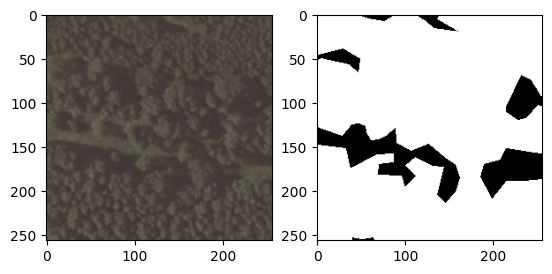

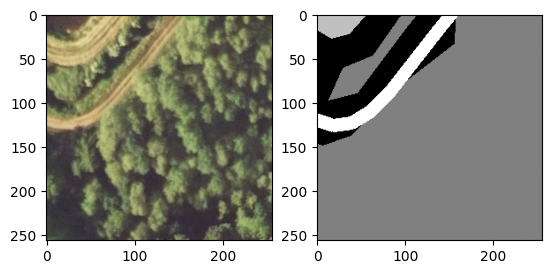

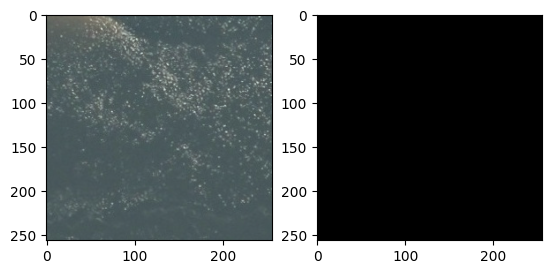

In [23]:
# Load the next batch of batch_size images
x, y = train_img_gen.__next__()

print(x.shape, y.shape)

# Make sure x has 3 layers (RGB)
assert x.shape[3] == 3

# Make sure y has n_classes layers
assert y.shape[3] == n_classes

for i in range(0, 3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.show()

Found 750 images belonging to 1 classes.
Found 750 images belonging to 1 classes.
(16, 256, 256, 3) (16, 256, 256, 5)


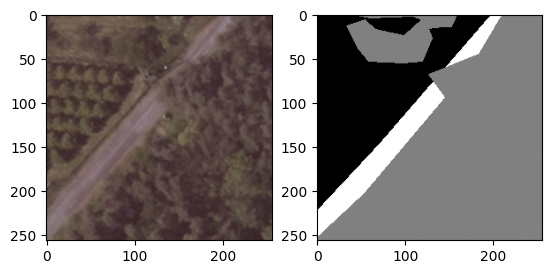

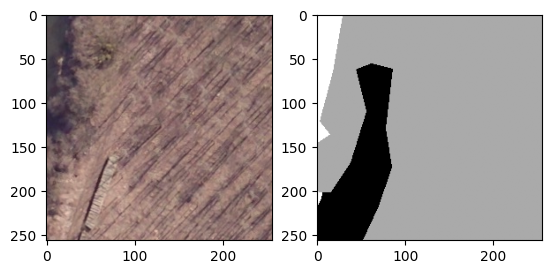

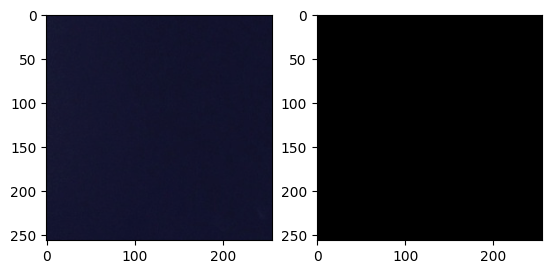

In [24]:
x_val, y_val = val_img_gen.__next__()

print(x_val.shape, y_val.shape)

# Make sure x has 3 layers (RGB)
assert x_val.shape[3] == 3

# Make sure y has n_classes layers
assert y_val.shape[3] == n_classes

for i in range(0, 3):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.show()


### Define the model metrics and load model

In [25]:
num_train_imgs = len([file for file in dir_train_img.iterdir() if file.is_file()])
num_val_images = len([file for file in dir_val_img.iterdir() if file.is_file()])

steps_per_epoch = num_train_imgs // batch_size
val_steps_per_epoch = num_val_images // batch_size

IMG_HEIGHT = x.shape[1]
IMG_WIDTH = x.shape[2]
IMG_CHANNELS = x.shape[3]

EPOCHS = 75

In [26]:
print(num_train_imgs)
print(num_val_images)
print(steps_per_epoch)
print(val_steps_per_epoch)

2250
750
140
46


### Use transfer learning using pretrained encoder in the U-Net

We use ***Intersection over Union (IoU)*** as evaluation metric (see [here](https://towardsdatascience.com/iou-a-better-detection-evaluation-metric-45a511185be1)). is used when calculating Mean average precision (mAP). It is a number from 0 to 1 that specifies the amount of overlap between the predicted and ground truth bounding box:

- an IoU of 0 means that there is no overlap between the boxes
- an IoU of 1 means that the union of the boxes is the same as their overlap indicating that they are completely overlapping

In [27]:
# Define the model
model = sm.Unet(
    BACKBONE,
    encoder_weights="imagenet",
    encoder_freeze=encoder_freeze,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    classes=len(classes),
    activation="softmax",
)

import tensorflow as tf

def custom_iou_score(gt, pr, **kwargs):
    gt = tf.cast(gt, dtype=tf.float32)
    pr = tf.cast(pr, dtype=tf.float32)
    return sm.metrics.iou_score(gt, pr, **kwargs)


model.compile(
    "Adam",
    loss=sm.losses.categorical_focal_jaccard_loss,
    metrics=[custom_iou_score],
)

# Other losses to try: categorical_focal_dice_loss, cce_jaccard_loss, cce_dice_loss, categorical_focal_loss

print(model.summary())
print(model.input_shape)

94592056/94592056 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)         │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_data                   │ (None, 256, 256, 3)    │              9 │ data[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 262, 262, 3)    │              0 │ bn_data[0][0]          │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv0 (Conv2D)            │ (None, 128, 128, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn0 (BatchNormalization)  │ (None, 128, 128, 64)   │            256 │ conv0[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu0 (Activation)        │ (None, 128, 128, 64)   │              0 │ bn0[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 130, 130, 64)   │              0 │ relu0[0][0]            │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pooling0 (MaxPooling2D)   │ (None, 64, 64, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn1          │ (None, 64, 64, 64)     │            256 │ pooling0[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu1        │ (None, 64, 64, 64)     │              0 │ stage1_unit1_bn1[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_conv1        │ (None, 64, 64, 64)     │          4,096 │ stage1_unit1_relu1[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn2          │ (None, 64, 64, 64)     │            256 │ stage1_unit1_conv1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu2        │ (None, 64, 64, 64)     │              0 │ stage1_unit1_bn2[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 66, 66, 64)     │              0 │ stage1_unit1_relu2[0]… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_conv2        │ (None, 64, 64, 64)     │         36,864 │ zero_padding2d_2[0][0] │
│ (Conv2D)             

 Total params: 32,561,694 (124.21 MB)

 Trainable params: 9,059,224 (34.56 MB)

 Non-trainable params: 23,502,470 (89.65 MB)

None
(None, 256, 256, 3)


In [28]:
from keras.callbacks import EarlyStopping

stop_early = EarlyStopping(
    monitor="val_iou_score", patience=7, verbose=1, mode='max'
)

In [29]:
# Fit the model
history = model.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    verbose=1,
    validation_data=val_img_gen,
    validation_steps=val_steps_per_epoch,
    callbacks=stop_early,
)

freeze = "freeze" if encoder_freeze else "nofreeze"

file_model = Path(
    dir_models, f"landcover_{BACKBONE}_{EPOCHS}_epochs_batch{batch_size}_{freeze}.hdf5"
)
model.save(file_model)

Epoch 1/75
140/140 ━━━━━━━━━━━━━━━━━━━━ 867s 6s/step - custom_iou_score: 0.3176 - loss: 0.7185 - val_custom_iou_score: 0.0763 - val_loss: 1.1572
Epoch 2/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 92s 657ms/step - custom_iou_score: 0.5580 - loss: 0.4752 - val_custom_iou_score: 0.0743 - val_loss: 1.3726
Epoch 3/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 587ms/step - custom_iou_score: 0.5892 - loss: 0.4418 - val_custom_iou_score: 0.0736 - val_loss: 1.2757
Epoch 4/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 73s 520ms/step - custom_iou_score: 0.6294 - loss: 0.4012 - val_custom_iou_score: 0.0748 - val_loss: 1.4061
Epoch 5/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 78s 561ms/step - custom_iou_score: 0.5898 - loss: 0.4487 - val_custom_iou_score: 0.1046 - val_loss: 1.2823
Epoch 6/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 590ms/step - custom_iou_score: 0.6666 - loss: 0.3591 - val_custom_iou_score: 0.2780 - val_loss: 0.8997
Epoch 7/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 81s 584ms/step - custom_iou_score: 0.6821 - loss: 0.3439 - val_custom_iou_score: 0.4034 - val_loss: 0.6789
Epoch 8/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 67s 482ms/step - custom_iou_score: 0.6738 - loss: 0.3527 - val_custom_iou_score: 0.5405 - val_loss: 0.5045
Epoch 9/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 80s 572ms/step - custom_iou_score: 0.6120 - loss: 0.4237 - val_custom_iou_score: 0.6633 - val_loss: 0.3611
Epoch 10/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 67s 478ms/step - custom_iou_score: 0.6864 - loss: 0.3377 - val_custom_iou_score: 0.6160 - val_loss: 0.4258
Epoch 11/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 79s 565ms/step - custom_iou_score: 0.6170 - loss: 0.4215 - val_custom_iou_score: 0.6874 - val_loss: 0.3355
Epoch 12/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 589ms/step - custom_iou_score: 0.7022 - loss: 0.3216 - val_custom_iou_score: 0.6792 - val_loss: 0.3427
Epoch 13/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 66s 473ms/step - custom_iou_score: 0.6994 - loss: 0.3244 - val_custom_iou_score: 0.6125 - val_loss: 0.4324
Epoch 14/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 79s 569ms/step - custom_iou_score: 0.6295 - loss: 0.4095 - val_custom_iou_score: 0.7064 - val_loss: 0.3144
Epoch 15/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 81s 583ms/step - custom_iou_score: 0.7100 - loss: 0.3135 - val_custom_iou_score: 0.6971 - val_loss: 0.3232
Epoch 16/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 66s 472ms/step - custom_iou_score: 0.7100 - loss: 0.3125 - val_custom_iou_score: 0.6356 - val_loss: 0.4028
Epoch 17/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 78s 562ms/step - custom_iou_score: 0.6457 - loss: 0.3865 - val_custom_iou_score: 0.7115 - val_loss: 0.3109
Epoch 18/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 588ms/step - custom_iou_score: 0.7355 - loss: 0.2854 - val_custom_iou_score: 0.7087 - val_loss: 0.3154
Epoch 19/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 587ms/step - custom_iou_score: 0.7311 - loss: 0.2893 - val_custom_iou_score: 0.7028 - val_loss: 0.3204
Epoch 20/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 66s 472ms/step - custom_iou_score: 0.7318 - loss: 0.2880 - val_custom_iou_score: 0.6312 - val_loss: 0.4105
Epoch 21/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 79s 568ms/step - custom_iou_score: 0.6410 - loss: 0.3977 - val_custom_iou_score: 0.7152 - val_loss: 0.3087
Epoch 22/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 83s 593ms/step - custom_iou_score: 0.7296 - loss: 0.2914 - val_custom_iou_score: 0.7248 - val_loss: 0.2969
Epoch 23/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 81s 582ms/step - custom_iou_score: 0.7456 - loss: 0.2755 - val_custom_iou_score: 0.7062 - val_loss: 0.3179
Epoch 24/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 589ms/step - custom_iou_score: 0.7286 - loss: 0.2913 - val_custom_iou_score: 0.7024 - val_loss: 0.3201
Epoch 25/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 468ms/step - custom_iou_score: 0.7439 - loss: 0.2765 - val_custom_iou_score: 0.6378 - val_loss: 0.4018
Epoch 26/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 80s 571ms/step - custom_iou_score: 0.6327 - loss: 0.4044 - val_custom_iou_score: 0.7264 - val_loss: 0.2967
Epoch 27/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 590ms/step - custom_iou_score: 0.7448 - loss: 0.2736 - val_custom_iou_score: 0.7298 - val_loss: 0.2906
Epoch 28/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 81s 582ms/step - custom_iou_score: 0.7385 - loss: 0.2807 - val_custom_iou_score: 0.7256 - val_loss: 0.2949
Epoch 29/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 468ms/step - custom_iou_score: 0.7476 - loss: 0.2722 - val_custom_iou_score: 0.6327 - val_loss: 0.4131
Epoch 30/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 469ms/step - custom_iou_score: 0.6565 - loss: 0.3795 - val_custom_iou_score: 0.6527 - val_loss: 0.3838
Epoch 31/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 468ms/step - custom_iou_score: 0.6605 - loss: 0.3773 - val_custom_iou_score: 0.6569 - val_loss: 0.3811
Epoch 32/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 465ms/step - custom_iou_score: 0.6646 - loss: 0.3687 - val_custom_iou_score: 0.6431 - val_loss: 0.3983
Epoch 33/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 468ms/step - custom_iou_score: 0.6647 - loss: 0.3708 - val_custom_iou_score: 0.6495 - val_loss: 0.3903
Epoch 34/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 80s 572ms/step - custom_iou_score: 0.6595 - loss: 0.3776 - val_custom_iou_score: 0.7231 - val_loss: 0.2982
Epoch 35/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 81s 582ms/step - custom_iou_score: 0.7551 - loss: 0.2635 - val_custom_iou_score: 0.7294 - val_loss: 0.2931
Epoch 36/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 588ms/step - custom_iou_score: 0.7561 - loss: 0.2628 - val_custom_iou_score: 0.7299 - val_loss: 0.2914
Epoch 37/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 64s 462ms/step - custom_iou_score: 0.7556 - loss: 0.2649 - val_custom_iou_score: 0.6489 - val_loss: 0.3910
Epoch 38/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 80s 572ms/step - custom_iou_score: 0.6734 - loss: 0.3634 - val_custom_iou_score: 0.7386 - val_loss: 0.2823
Epoch 39/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 64s 461ms/step - custom_iou_score: 0.7556 - loss: 0.2629 - val_custom_iou_score: 0.6484 - val_loss: 0.3917
Epoch 40/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 80s 573ms/step - custom_iou_score: 0.6833 - loss: 0.3486 - val_custom_iou_score: 0.7317 - val_loss: 0.2903
Epoch 41/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 585ms/step - custom_iou_score: 0.7628 - loss: 0.2558 - val_custom_iou_score: 0.7393 - val_loss: 0.2831
Epoch 42/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 590ms/step - custom_iou_score: 0.7580 - loss: 0.2618 - val_custom_iou_score: 0.7369 - val_loss: 0.2848
Epoch 43/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 469ms/step - custom_iou_score: 0.7652 - loss: 0.2522 - val_custom_iou_score: 0.6625 - val_loss: 0.3740
Epoch 44/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 463ms/step - custom_iou_score: 0.6954 - loss: 0.3366 - val_custom_iou_score: 0.6585 - val_loss: 0.3869
Epoch 45/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 80s 571ms/step - custom_iou_score: 0.6825 - loss: 0.3537 - val_custom_iou_score: 0.7366 - val_loss: 0.2837
Epoch 46/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 81s 583ms/step - custom_iou_score: 0.7585 - loss: 0.2611 - val_custom_iou_score: 0.7221 - val_loss: 0.3021
Epoch 47/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 467ms/step - custom_iou_score: 0.7801 - loss: 0.2384 - val_custom_iou_score: 0.6598 - val_loss: 0.3786
Epoch 48/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 464ms/step - custom_iou_score: 0.6744 - loss: 0.3583 - val_custom_iou_score: 0.6466 - val_loss: 0.3952
Epoch 49/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 468ms/step - custom_iou_score: 0.6780 - loss: 0.3570 - val_custom_iou_score: 0.6498 - val_loss: 0.3848
Epoch 50/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 464ms/step - custom_iou_score: 0.6818 - loss: 0.3538 - val_custom_iou_score: 0.6553 - val_loss: 0.3849
Epoch 51/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 468ms/step - custom_iou_score: 0.6830 - loss: 0.3524 - val_custom_iou_score: 0.6617 - val_loss: 0.3760
Epoch 52/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 78s 563ms/step - custom_iou_score: 0.6888 - loss: 0.3435 - val_custom_iou_score: 0.7234 - val_loss: 0.2983
Epoch 53/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 66s 471ms/step - custom_iou_score: 0.7743 - loss: 0.2433 - val_custom_iou_score: 0.6699 - val_loss: 0.3660
Epoch 54/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 79s 570ms/step - custom_iou_score: 0.6758 - loss: 0.3567 - val_custom_iou_score: 0.7459 - val_loss: 0.2759
Epoch 55/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 83s 592ms/step - custom_iou_score: 0.7859 - loss: 0.2310 - val_custom_iou_score: 0.7278 - val_loss: 0.2932
Epoch 56/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 466ms/step - custom_iou_score: 0.7919 - loss: 0.2247 - val_custom_iou_score: 0.6651 - val_loss: 0.3810
Epoch 57/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 464ms/step - custom_iou_score: 0.6993 - loss: 0.3338 - val_custom_iou_score: 0.6489 - val_loss: 0.3935
Epoch 58/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 79s 569ms/step - custom_iou_score: 0.6788 - loss: 0.3555 - val_custom_iou_score: 0.7389 - val_loss: 0.2840
Epoch 59/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 465ms/step - custom_iou_score: 0.7841 - loss: 0.2331 - val_custom_iou_score: 0.6469 - val_loss: 0.3931
Epoch 60/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 467ms/step - custom_iou_score: 0.7024 - loss: 0.3306 - val_custom_iou_score: 0.6748 - val_loss: 0.3621
Epoch 61/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 465ms/step - custom_iou_score: 0.6850 - loss: 0.3490 - val_custom_iou_score: 0.6600 - val_loss: 0.3790
Epoch 62/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 465ms/step - custom_iou_score: 0.6940 - loss: 0.3399 - val_custom_iou_score: 0.6633 - val_loss: 0.3767
Epoch 63/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 80s 571ms/step - custom_iou_score: 0.6869 - loss: 0.3477 - val_custom_iou_score: 0.7286 - val_loss: 0.2936
Epoch 64/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 464ms/step - custom_iou_score: 0.7909 - loss: 0.2271 - val_custom_iou_score: 0.6546 - val_loss: 0.3885
Epoch 65/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 466ms/step - custom_iou_score: 0.6836 - loss: 0.3534 - val_custom_iou_score: 0.6731 - val_loss: 0.3630
Epoch 66/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 79s 568ms/step - custom_iou_score: 0.6937 - loss: 0.3415 - val_custom_iou_score: 0.7510 - val_loss: 0.2696
Epoch 67/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 588ms/step - custom_iou_score: 0.7996 - loss: 0.2167 - val_custom_iou_score: 0.7390 - val_loss: 0.2820
Epoch 68/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 468ms/step - custom_iou_score: 0.8058 - loss: 0.2091 - val_custom_iou_score: 0.6729 - val_loss: 0.3639
Epoch 69/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 66s 471ms/step - custom_iou_score: 0.7039 - loss: 0.3298 - val_custom_iou_score: 0.6637 - val_loss: 0.3773
Epoch 70/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 66s 470ms/step - custom_iou_score: 0.6899 - loss: 0.3469 - val_custom_iou_score: 0.6455 - val_loss: 0.3971
Epoch 71/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 80s 571ms/step - custom_iou_score: 0.6851 - loss: 0.3507 - val_custom_iou_score: 0.7404 - val_loss: 0.2826
Epoch 72/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 64s 459ms/step - custom_iou_score: 0.7979 - loss: 0.2186 - val_custom_iou_score: 0.6562 - val_loss: 0.3851
Epoch 73/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 80s 574ms/step - custom_iou_score: 0.7037 - loss: 0.3286 - val_custom_iou_score: 0.7429 - val_loss: 0.2804
Epoch 74/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 466ms/step - custom_iou_score: 0.8014 - loss: 0.2156 - val_custom_iou_score: 0.6750 - val_loss: 0.3624
Epoch 75/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 469ms/step - custom_iou_score: 0.7047 - loss: 0.3283 - val_custom_iou_score: 0.6646 - val_loss: 0.3746


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Plot training and validation IoU and loss at each epoch

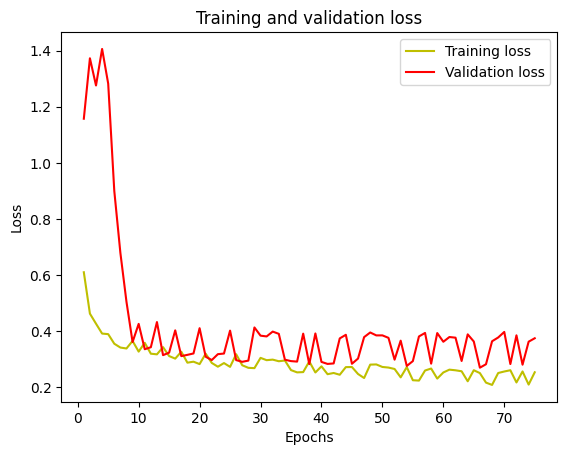

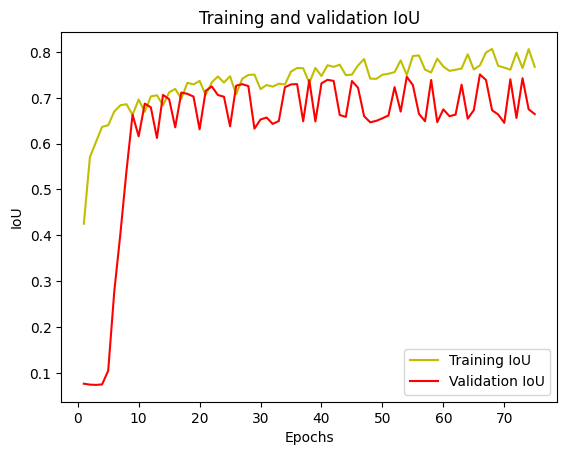

In [30]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "y", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["custom_iou_score"]
val_acc = history.history["val_custom_iou_score"]

plt.plot(epochs, acc, "y", label="Training IoU")
plt.plot(epochs, val_acc, "r", label="Validation IoU")
plt.title("Training and validation IoU")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.legend()
plt.show()

### Evaulate model on test data

In [31]:

model = load_model(file_model, compile=False)
model.save(file_model)
# Test generator using validation data.
test_image_batch, test_mask_batch = val_img_gen.__next__()

# Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Mean IoU = 0.8074797


## Calculation

- Accuracy is typically used for classification tasks, where the goal is to predict discrete classes. In semantic segmentation, accuracy measures the percentage of pixels that are correctly classified.

- R-squared (R2) is commonly used in regression problems to measure the goodness of fit. It's less relevant in semantic segmentation, which is primarily a classification task.
- Mean Squared Error (MSE) is a regression metric that quantifies the average squared difference between predicted and true values. In semantic segmentation, it can be applied to the pixel-wise probabilities or class labels. However, it might not be the most informative metric for this task.
- Loss is the function used to optimize the model during training. In semantic segmentation, various loss functions can be employed, such as categorical cross-entropy or Dice loss. The loss value reflects the model's overall performance during training.

In [32]:
# Access the loss value from the training history
loss = history.history['loss'][-1]  # Get the last loss value
print("Loss:", loss)

from sklearn.metrics import mean_squared_error

# Flatten predictions and ground truth
y_true_flat = test_mask_batch_argmax.flatten()  # Or use original probabilities
y_pred_flat = test_pred_batch_argmax.flatten()  # Or use original probabilities

# Calculate MSE
mse = mean_squared_error(y_true_flat, y_pred_flat)
print("Mean Squared Error:", mse)


from sklearn.metrics import accuracy_score

# Flatten predictions and ground truth
y_true_flat = test_mask_batch_argmax.flatten()
y_pred_flat = test_pred_batch_argmax.flatten()

# Calculate accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print("Accuracy:", accuracy)


# less Relevant
from sklearn.metrics import r2_score

# Assuming you have continuous predictions (e.g., probabilities)
y_true_flat = test_mask_batch.flatten()  # Use original probabilities
y_pred_flat = test_pred_batch.flatten()  # Use original probabilities

# Calculate R-squared
r2 = r2_score(y_true_flat, y_pred_flat)
print("R-squared:", r2)

Loss: 0.2533450722694397
Mean Squared Error: 0.5563068389892578
Accuracy: 0.919647216796875
R-squared: 0.8147297114732862


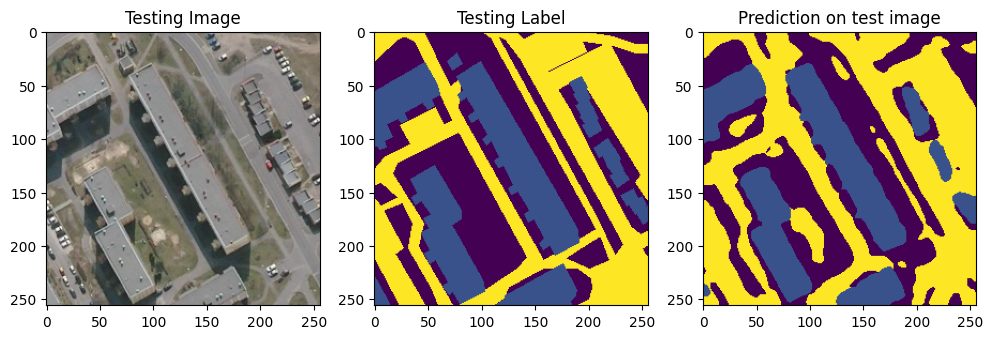

In [33]:
# View a few images, masks and corresponding predictions.
img_num = random.randint(0, test_image_batch.shape[0] - 1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title("Testing Image")
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title("Testing Label")
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title("Prediction on test image")
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()